# Introduction

Heart disease is a general term that describes several types of heart conditions, and in this dataset, it is shown as the percentage narrowing of blood vessels. In this data set, researchers have collected data from individuals residing in Cleveland, USA. This data set contains 14 attributes of individuals, such as age, biological sex (1 = male; 0 = female), years smoking, serum cholestoral level, resting blood pressure as well as diagnosis of heart disease based on the percentage of blood vessel diameter narrowing ( value of 0 = no, value >=1 = yes). The other 13 attributes may or may not contribute to having heart disease. We have learned that high blood pressure, high cholestorol level and smoking are some of the most common risk factors of heart disease. In this study, we want to explore the relationship between high resting blood pressure along with serum chloesterol levels and the likelihood of having heart disease. 

The main question we have for this study is: !!! change it to how well does xx, xx, and xx (whatever we choose as our predictors) predict heart disease in Cleveland? (and our answer to the question would be the accuracy of our model) Do high resting blood pressure and high cholesterol levels increase the likelihood of people having heart disease?

To answer this question, we will be using processed.cleveland.data in the heart disease dataset. It includes variables age, sex, types of chest pain (cp), resting blood pressure (trestbps), cholesterol level (chol), fasting blood sugar (fbs), resting electrocardiographic measurement (restecg), max heart rate (thalach), trigger (exang, exercise=1, other= 0), exercise induced depression (oldpeak), slope of the peak exercise ST segment (slope), number of vessels colored by fluoroscopy (ca, ranges from 0-3), thal (3 = normal; 6 = fixed defect; 7 = reversable defect), and diagnosis of heart disease(num). All of the above factors may or may not affect the chance of having heart disease. In order to perform our data analysis, we need to further wrangle the data as shown below.


# Preliminary Explorotary Data Analysis

In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 8)

set.seed(9999)

As we download the file processed_cleveland.data and opened it in a text editor, we can see that all the variables for observations are separated by commas. We can go ahead and read in the dataset using read_csv.

In [23]:
cleveland_data_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
cleveland_data_raw

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


As shown on the table, the data set follows the criterion for tidy data: each variable forms a column, each observation forms a row, and each cell is a single measurement. The only element missing is the column titles, and we can manually assign them according to the data description on the web.


In [25]:
cleveland_data <- cleveland_data_raw %>%
                  rename(age = X1, sex = X2, cp= X3, trestbps = X4, chol= X5, fbs = X6, restecg = X7, thalach = X8, exang = X9, oldpeak = X10, slope = X11, ca = X12, thal = X13, num = X14)
cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


As mentioned in the description of the data set , the blood vessel narrowing level only contain Value 0: < 50% diameter narrowing, Value 1: > 50% diameter narrowing. Therefore , we converted num values >=1 all into 1 so that there are only two classes - 0 = no heart disease, 1 = have heart disease. We also standardize the column value for resting blood pressure, serel chloestoral level and age so that they all contribute equally to the k-nearest neighbour prediction

In [26]:
#Cleaning and wrangling
#turn 1 2 3 4 into 1 
cleveland_data_clean <- mutate(cleveland_data, num = ifelse(num >= 1, 1, 0))%>%
                        filter_all( all_vars(!(.  %in% c('?'))))%>% #remove row with missing value 
                        mutate(scaled_trestbps = scale(trestbps, center = TRUE), 
                               scaled_chol = scale(chol, center = TRUE),
                               scaled_age = scale(age, center = TRUE)) #center trestbps ,chol,age column which are more related to heart disease

cleveland_data_clean

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,scaled_trestbps,scaled_chol,scaled_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0.74911571,-0.27597761,0.9346033
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1,1.59357687,0.74330055,1.3766051
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,-0.65831955,-0.35290426,1.3766051
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,-0.09534545,0.05096067,-1.9384088
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1,-1.22129365,0.3202040,-1.0544051
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,1,0.69281830,-1.0452441,1.4871056
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1,-0.09534545,-2.2376073,0.2716005
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1,-0.09534545,-0.2182826,0.2716005


In [29]:
#spliting the dataset into training and testing sets
cleveland_split <- initial_split(cleveland_data_clean, prop = 0.75, strata = num)  
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)
cleveland_training

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,scaled_trestbps,scaled_chol,scaled_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0.74911571,-0.27597761,0.9346033
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1,1.59357687,0.74330055,1.3766051
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,-0.09534545,0.05096067,-1.9384088
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,-0.65831955,-0.21828262,0.1611000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
41,1,2,120,157,0,0,182,0,0.0,1,0.0,3.0,0,-0.65831955,-1.7375840,-1.4964070
59,1,4,164,176,1,2,90,0,1.0,2,2.0,6.0,1,1.81876651,-1.3721824,0.4926014
57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1,0.46762866,-0.1221243,0.2716005
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1,-0.09534545,-2.2376073,0.2716005


## Training Data Summary 


In [30]:
#summary and mean values


#missing values are removed in the cleaning process (6 missing values in total)

# cleveland_training %>%
# group_by(num)%>%
# summarize(n=n())

# cleveland_training %>%
# summarize(n=n())

# cleveland_training %>%
# mutate (avg_trestbps = mean(trestbps), 
#        avg_chol = mean(chol))%>%
# select (avg_trestbps,avg_chol)%>%
# slice (1)

# ↑where we get our value for the table 
sum_table <- data.frame(without_hd = 120, with_hd = 103, n_of_row = 223, avg_trestbps = 132.3453, avg_chol=245.148)
sum_table

without_hd,with_hd,n_of_row,avg_trestbps,avg_chol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
120,103,223,132.3453,245.148


## Training Data Predictor Data Plot 



Below we show the distribution of standardized resting blood pressure and serum cholesterol level in the scatter plot with color code indicating the presence of heart disease, and it is also a sample visualization of how our project will look like.



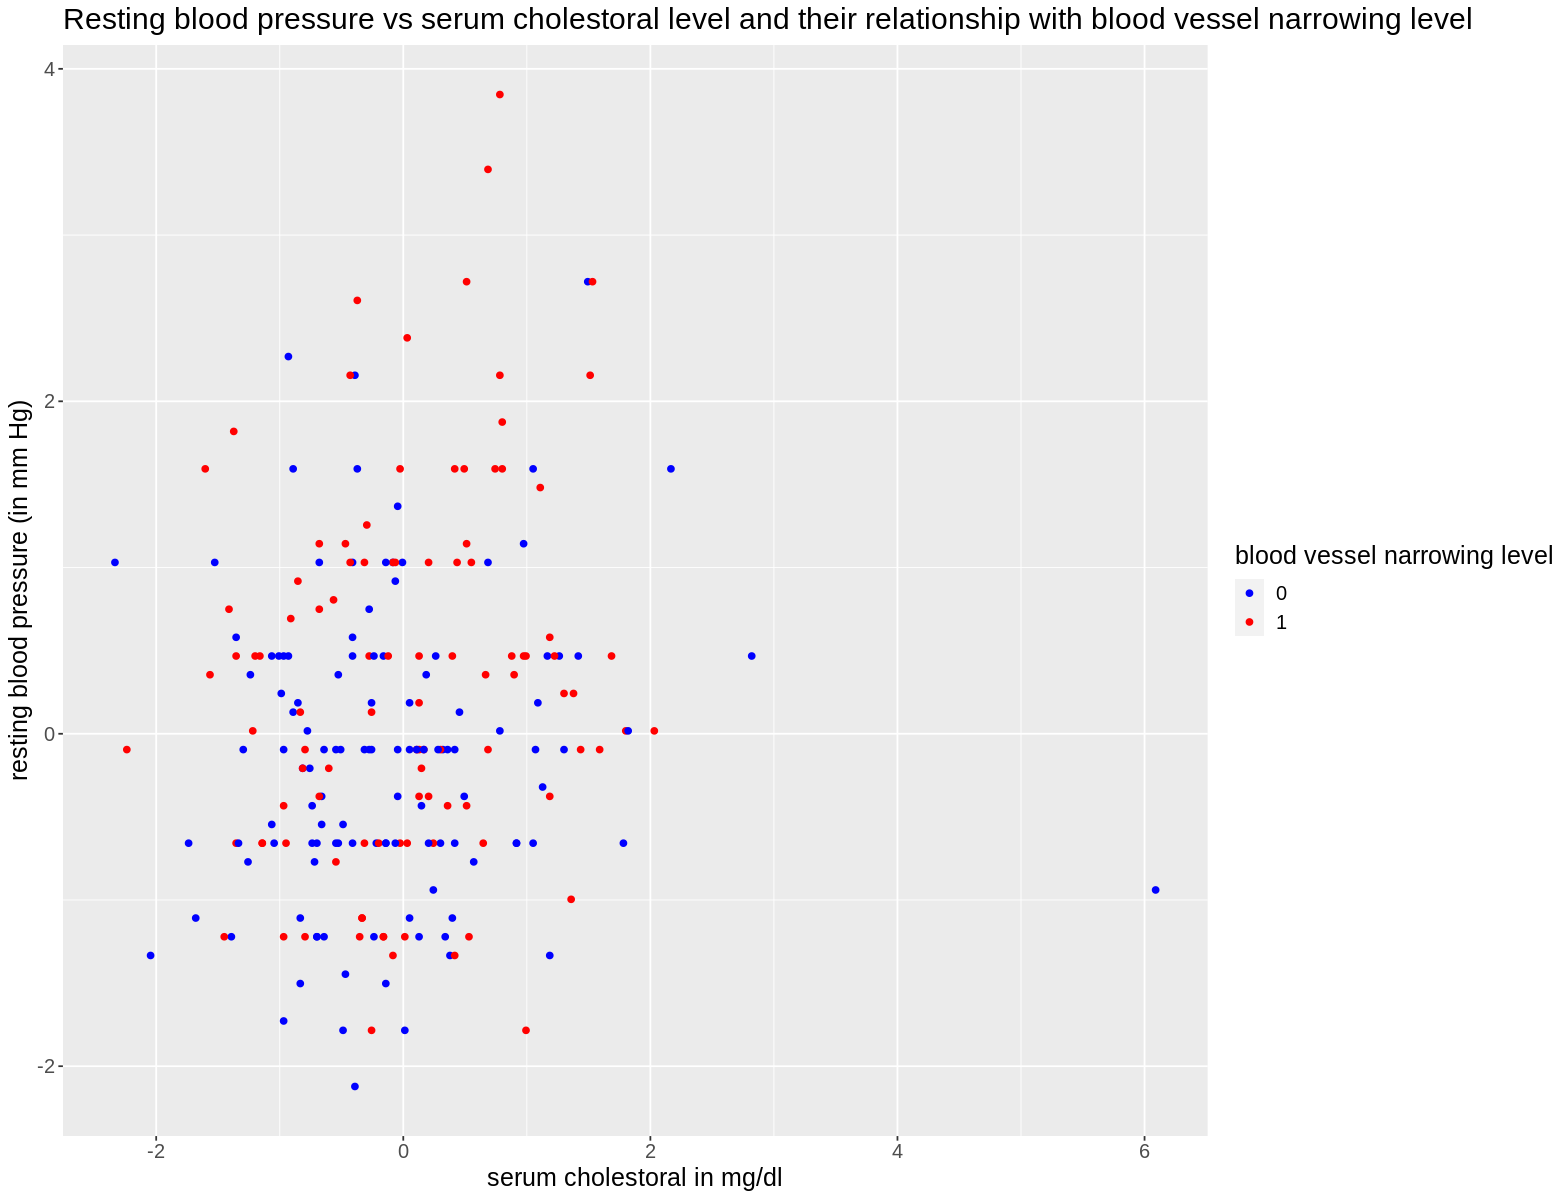

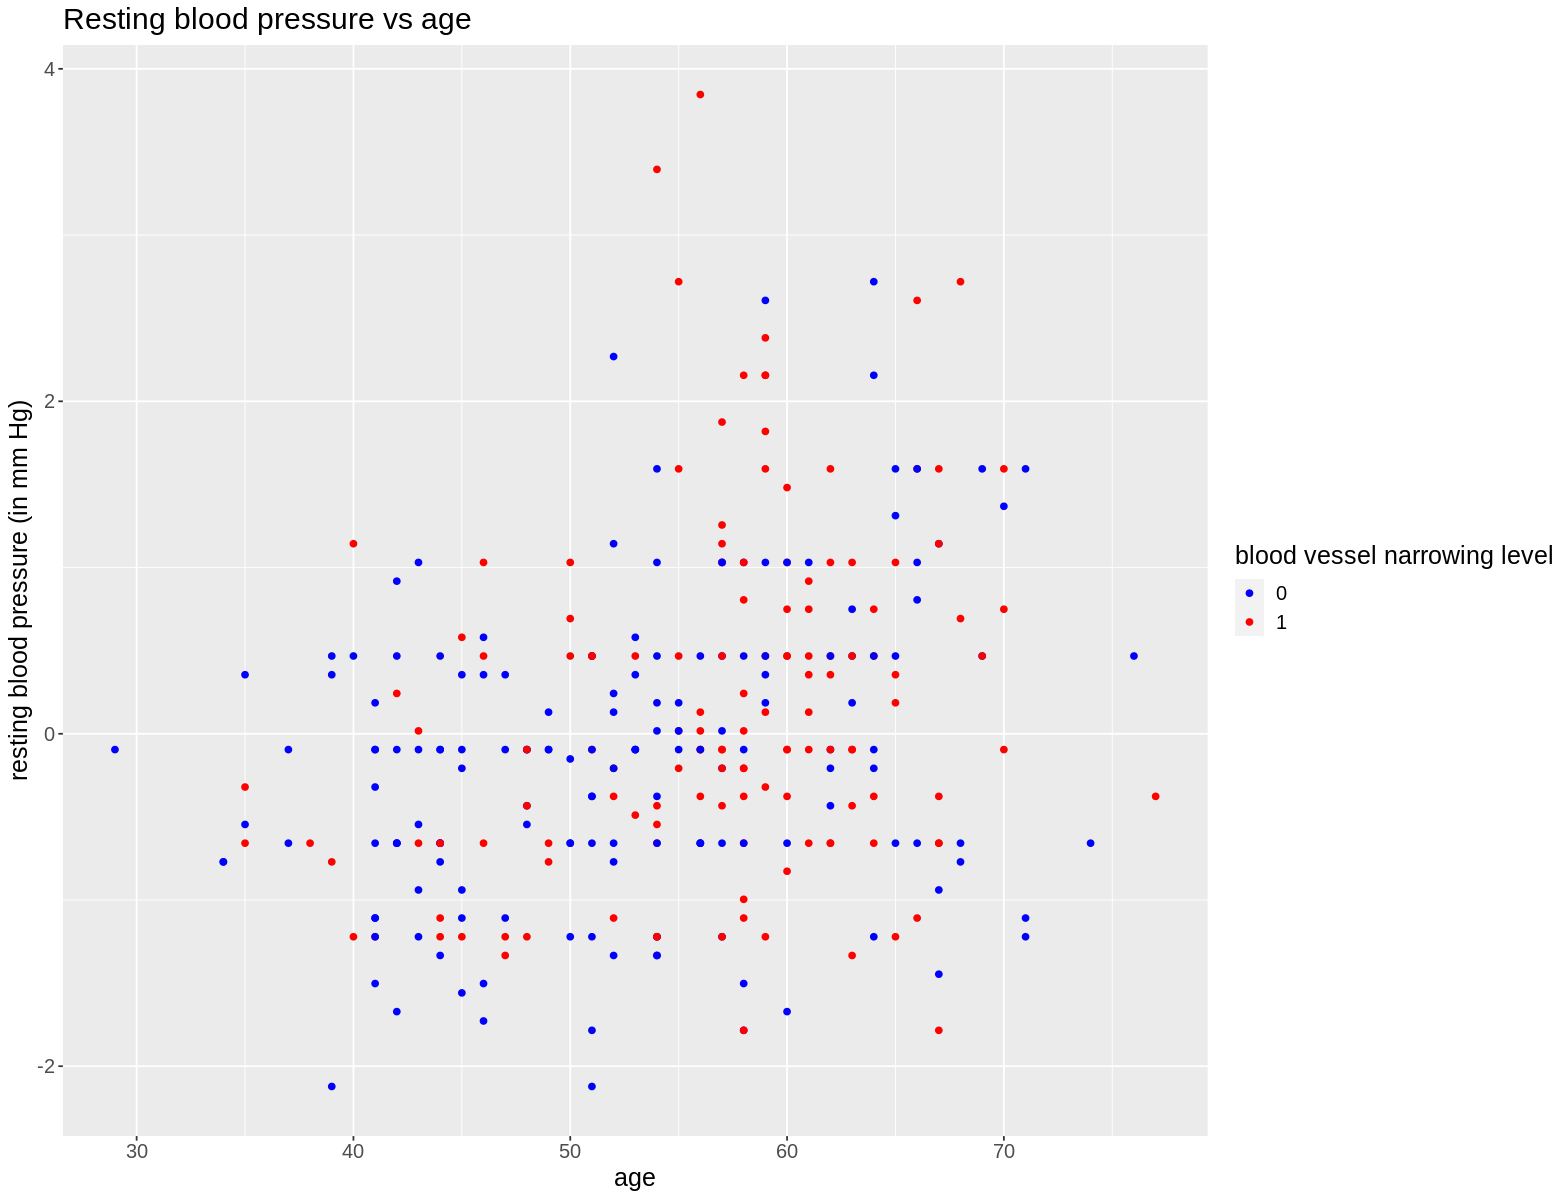

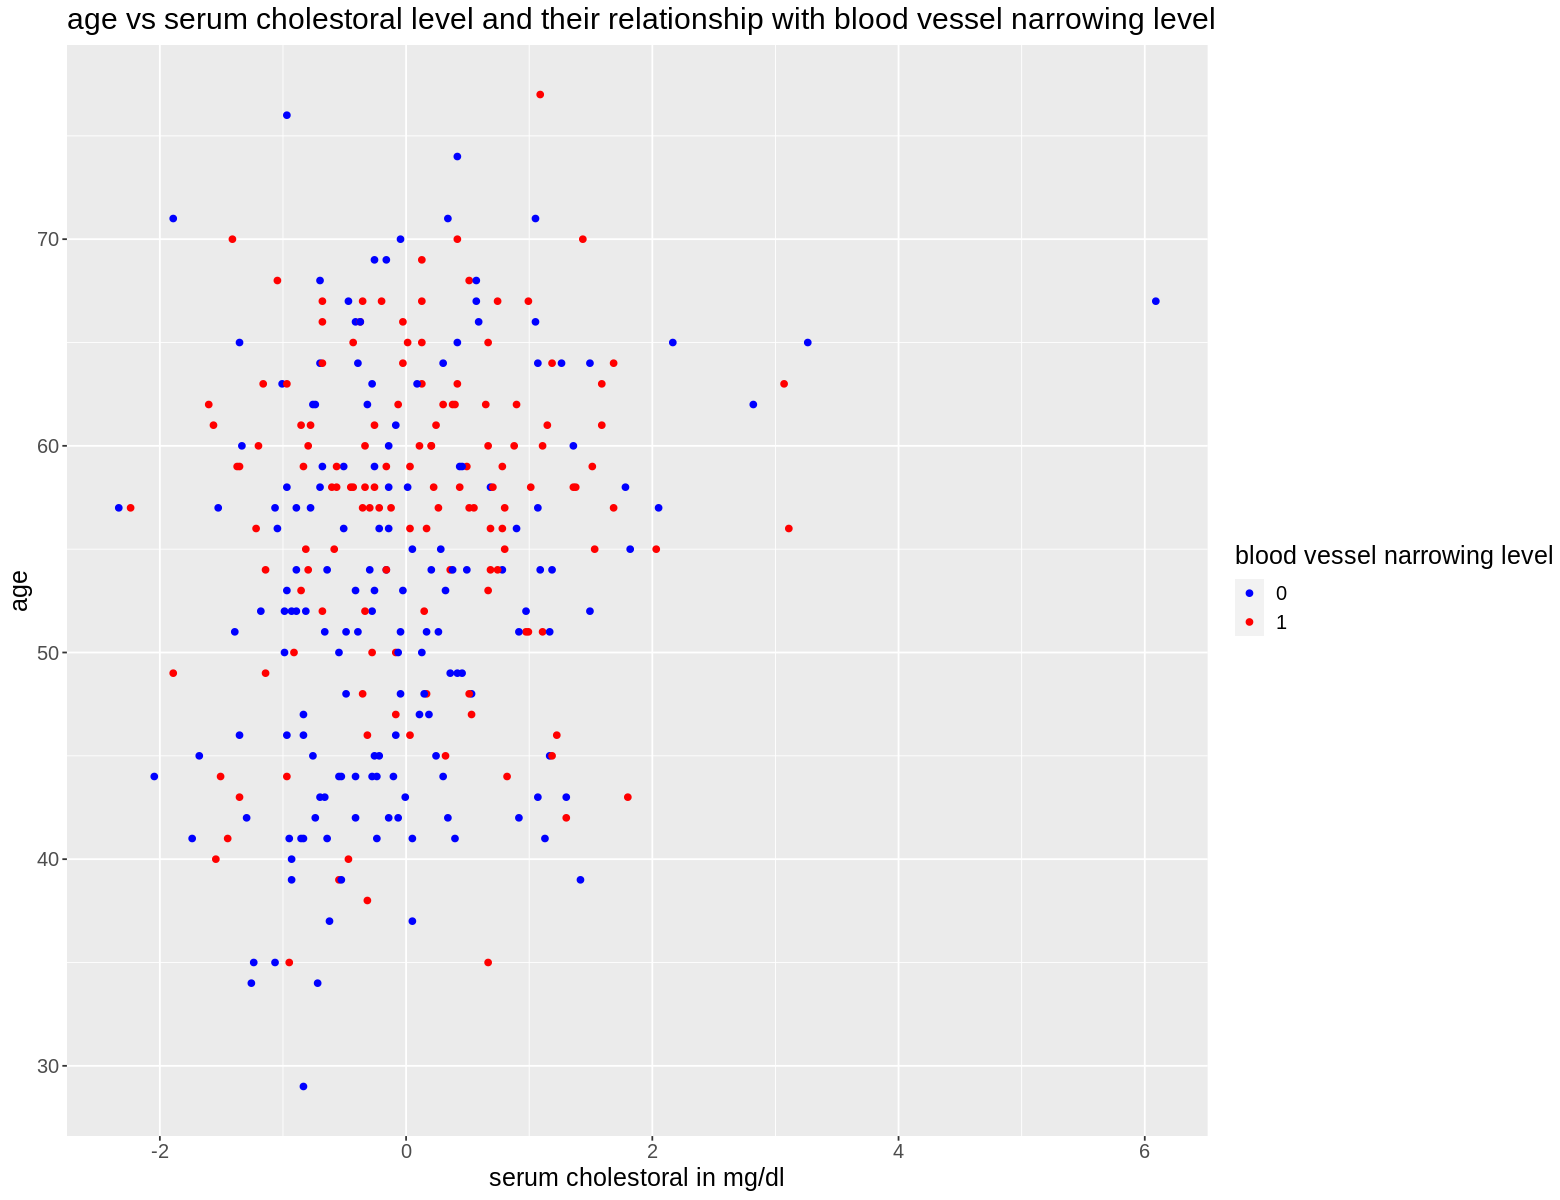

In [31]:
options(repr.plot.width = 13, repr.plot.height = 10)
plotA <- cleveland_training %>%
         ggplot(aes(x=scaled_chol, y = scaled_trestbps, color = as_factor(num))) +
         geom_point() +
         labs (x = "serum cholestoral in mg/dl", y = "resting blood pressure (in mm Hg)", color = "blood vessel narrowing level") +
         scale_color_manual(labels = c("0", "1"), values = c("blue", "red")) +
         theme(text = element_text(size =15)) +
         ggtitle("Resting blood pressure vs serum cholestoral level and their relationship with blood vessel narrowing level")

plotA

plotB <- cleveland_data_clean %>%
         ggplot (aes (x=age, y = scaled_trestbps, colour = as_factor(num))) +
         geom_point() +
         labs (x= "age" , y= "resting blood pressure (in mm Hg)", color = "blood vessel narrowing level") +
         scale_color_manual(labels = c("0", "1" ), values = c("blue",  "red")) +
         theme (text = element_text (size =15 )) +
         ggtitle("Resting blood pressure vs age ")

plotB

plotC <- cleveland_data_clean %>%
         ggplot(aes(x=scaled_chol, y = age, color = as_factor(num))) +
         geom_point() +
         labs(x = "serum cholestoral in mg/dl", y = "age", color = "blood vessel narrowing level") +
         scale_color_manual(labels = c("0", "1"), values = c("blue", "red")) +
         theme(text = element_text (size =15)) +
         ggtitle("age vs serum cholestoral level and their relationship with blood vessel narrowing level")
 plotC

# Method 

We hypothesize that resting blood pressure and serum chloestoral levels are most related to heart disease, so We will use the two columns “trestbps” and “chol”, as well as num (have / don’t have heart disease) in our data analysis.


We plan to use scatter plots to visualize our results, with two factors on each axis, and possibly different colored regions to indicate whether the data points have heart disease.


# Expected Outcomes and Significance


We expect to find that resting blood pressure and serum cholesteral level together correlate with heart disease: they would possibly have a strong/medium positive correlation with the likelihood of having heart disease, and we speculate that these factors might amplify the effect of each other (that is, people with high levels in both factors are more likely to have heart disease). Once we conduct the analysis and obtain our results, we can inform related public health agencies about our conclusion and promote healthy actions. For example, if we found cholesterol is contributing strongly to heart disease (strong correlation), then this finding can inspire the health department to promote healthy diet in the public, such as eating food with less serum cholesterol levels. Future questions can be and not limited to: what attributes or behaviours are correlated with high resting blood pressure/cholestrol level, given a patient’s blood pressure and cholestrol level, can we predict if they have heart disease, etc.




In this project proposal, we have outlined the main question and procedure of our data analysis. We will continue conducting the study on predicting heart disease, and we hope to create a meaningful and thoughtful data analysis moving on.

